# CMSC320 Fall 2022 Final Project- Riya Kukadia and Amartya Patel

In [1]:
# Topic- Analysing UFO Sightings around the world.

# Contributors: Riya Kukadia () and Amartya Patel (117183986)

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas
import sys
import io

In [3]:
# Step 1: Data Collection/Curation
# Since we are using a ready to use dataset, there is no need to parse the data.
# We have obtained this dataset from kaggle.com
# Link:
UFO_Dataframe = pd.read_csv('scrubbed.csv', low_memory=False)

UFO_Dataframe.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [4]:
# Step 2: Data Management/Representation

# We deal with missing locations by tagging them as 'unkown'.
UFO_Dataframe = UFO_Dataframe.fillna('unknown')


# It woudld be better to separate the date and time. Doing so could possibly help in better data analysis. 
# Thus, we subsequently separate the 'datetime' column into two separate columns "date" and "time".
UFO_Dataframe['datetime'] = UFO_Dataframe['datetime'].apply(lambda x: x.split())
UFO_Dataframe['date'] = UFO_Dataframe['datetime'].apply(lambda x: x[0])
UFO_Dataframe['time'] = UFO_Dataframe['datetime'].apply(lambda x: x[1])
del(UFO_Dataframe['datetime'])

# Next, for those rows that have a time such as '24:00', we change it to '00:00' and add a day to its date. 
UFO_Dataframe['date'] = pd.to_datetime(UFO_Dataframe['date'])
UFO_Dataframe['next_day'] = (UFO_Dataframe['time'] == '24:00') # Rows where the time is '24:00'
UFO_Dataframe.loc[UFO_Dataframe['next_day'] == True, 'date'] = UFO_Dataframe['date'] + pd.Timedelta(days=1) # Add a day
UFO_Dataframe.loc[UFO_Dataframe['next_day'] == True, 'time'] = '00:00' # Set time to '00:00'
del(UFO_Dataframe['next_day'])

# Convert the 'date' and 'time' to type datetime.
UFO_Dataframe['time'] = pd.to_datetime(UFO_Dataframe['time']).dt.time

UFO_Dataframe['date posted'] = pd.to_datetime(UFO_Dataframe['date posted'])

# Duration(seconds) contains the same information in a much more readable form, thus we do not really need this column. 
del(UFO_Dataframe["duration (hours/min)"]) 

# Rename the columns for better effect.
UFO_Dataframe.columns = ["City", "State", "Country", "Shape", "Duration (seconds)", "Notes/Comments", "Date Posted", "Latitude", "Longitude", "Date Observed", "Time Observed"]

# Order the columns for better effect.
UFO_Dataframe = UFO_Dataframe[["Date Observed", "Time Observed", "City", "State", "Country", "Latitude", "Longitude", "Date Posted", "Shape", "Duration (seconds)", "Notes/Comments"]]

# Next while studying the dataframe, we were able to find that one of the latitudes had invalid data.
# Consequently we found its index and dropped that row. 
UFO_Dataframe.loc[UFO_Dataframe['Latitude'] == '33q.200088']
UFO_Dataframe = UFO_Dataframe.drop(43782)

# Concerend Dataframe after cleaning the data.
UFO_Dataframe.head()

,Date Observed,Time Observed,City,State,Country,Latitude,Longitude,Date Posted,Shape,Duration (seconds),Notes/Comments
0,1949-10-10,20:30:00,san marcos,tx,us,29.8830556,-97.941111,2004-04-27,cylinder,2700,This event took place in early fall around 194...
1,1949-10-10,21:00:00,lackland afb,tx,unknown,29.38421,-98.581082,2005-12-16,light,7200,1949 Lackland AFB&#44 TX. Lights racing acros...
2,1955-10-10,17:00:00,chester (uk/england),unknown,gb,53.2,-2.916667,2008-01-21,circle,20,Green/Orange circular disc over Chester&#44 En...
3,1956-10-10,21:00:00,edna,tx,us,28.9783333,-96.645833,2004-01-17,circle,20,My older brother and twin sister were leaving ...
4,1960-10-10,20:00:00,kaneohe,hi,us,21.4180556,-157.803611,2004-01-22,light,900,AS a Marine 1st Lt. flying an FJ4B fighter/att...


In [5]:
# Step 3: Exploratory Data Analysis

# Since, the topic of UFO's is extremely intriguing, we can first see the distribution of the UFO sightings all across the 
# world. This can help us visually to conculde which areas (particularly different countries) of the world have had more 
# UFO sightings as compared to other areas.

# To do so we can use geopandas, which will be best for a situation such as this.

#Geo_Dataframe = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(UFO_Dataframe['Longitude '], UFO_Dataframe['Latitude']))
#UFO_World_Plot = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#ax = UFO_World_Plot.plot(color='white', edgecolor='black', figsize=(35, 35))

# We can now plot our 'Geo_Dataframe'.
#Geo_Dataframe.plot(ax=ax, color='red', markersize=2, legend=True)

#plt.show()

# Thus, the following plot shows the distribution of UFO sightings across the world.

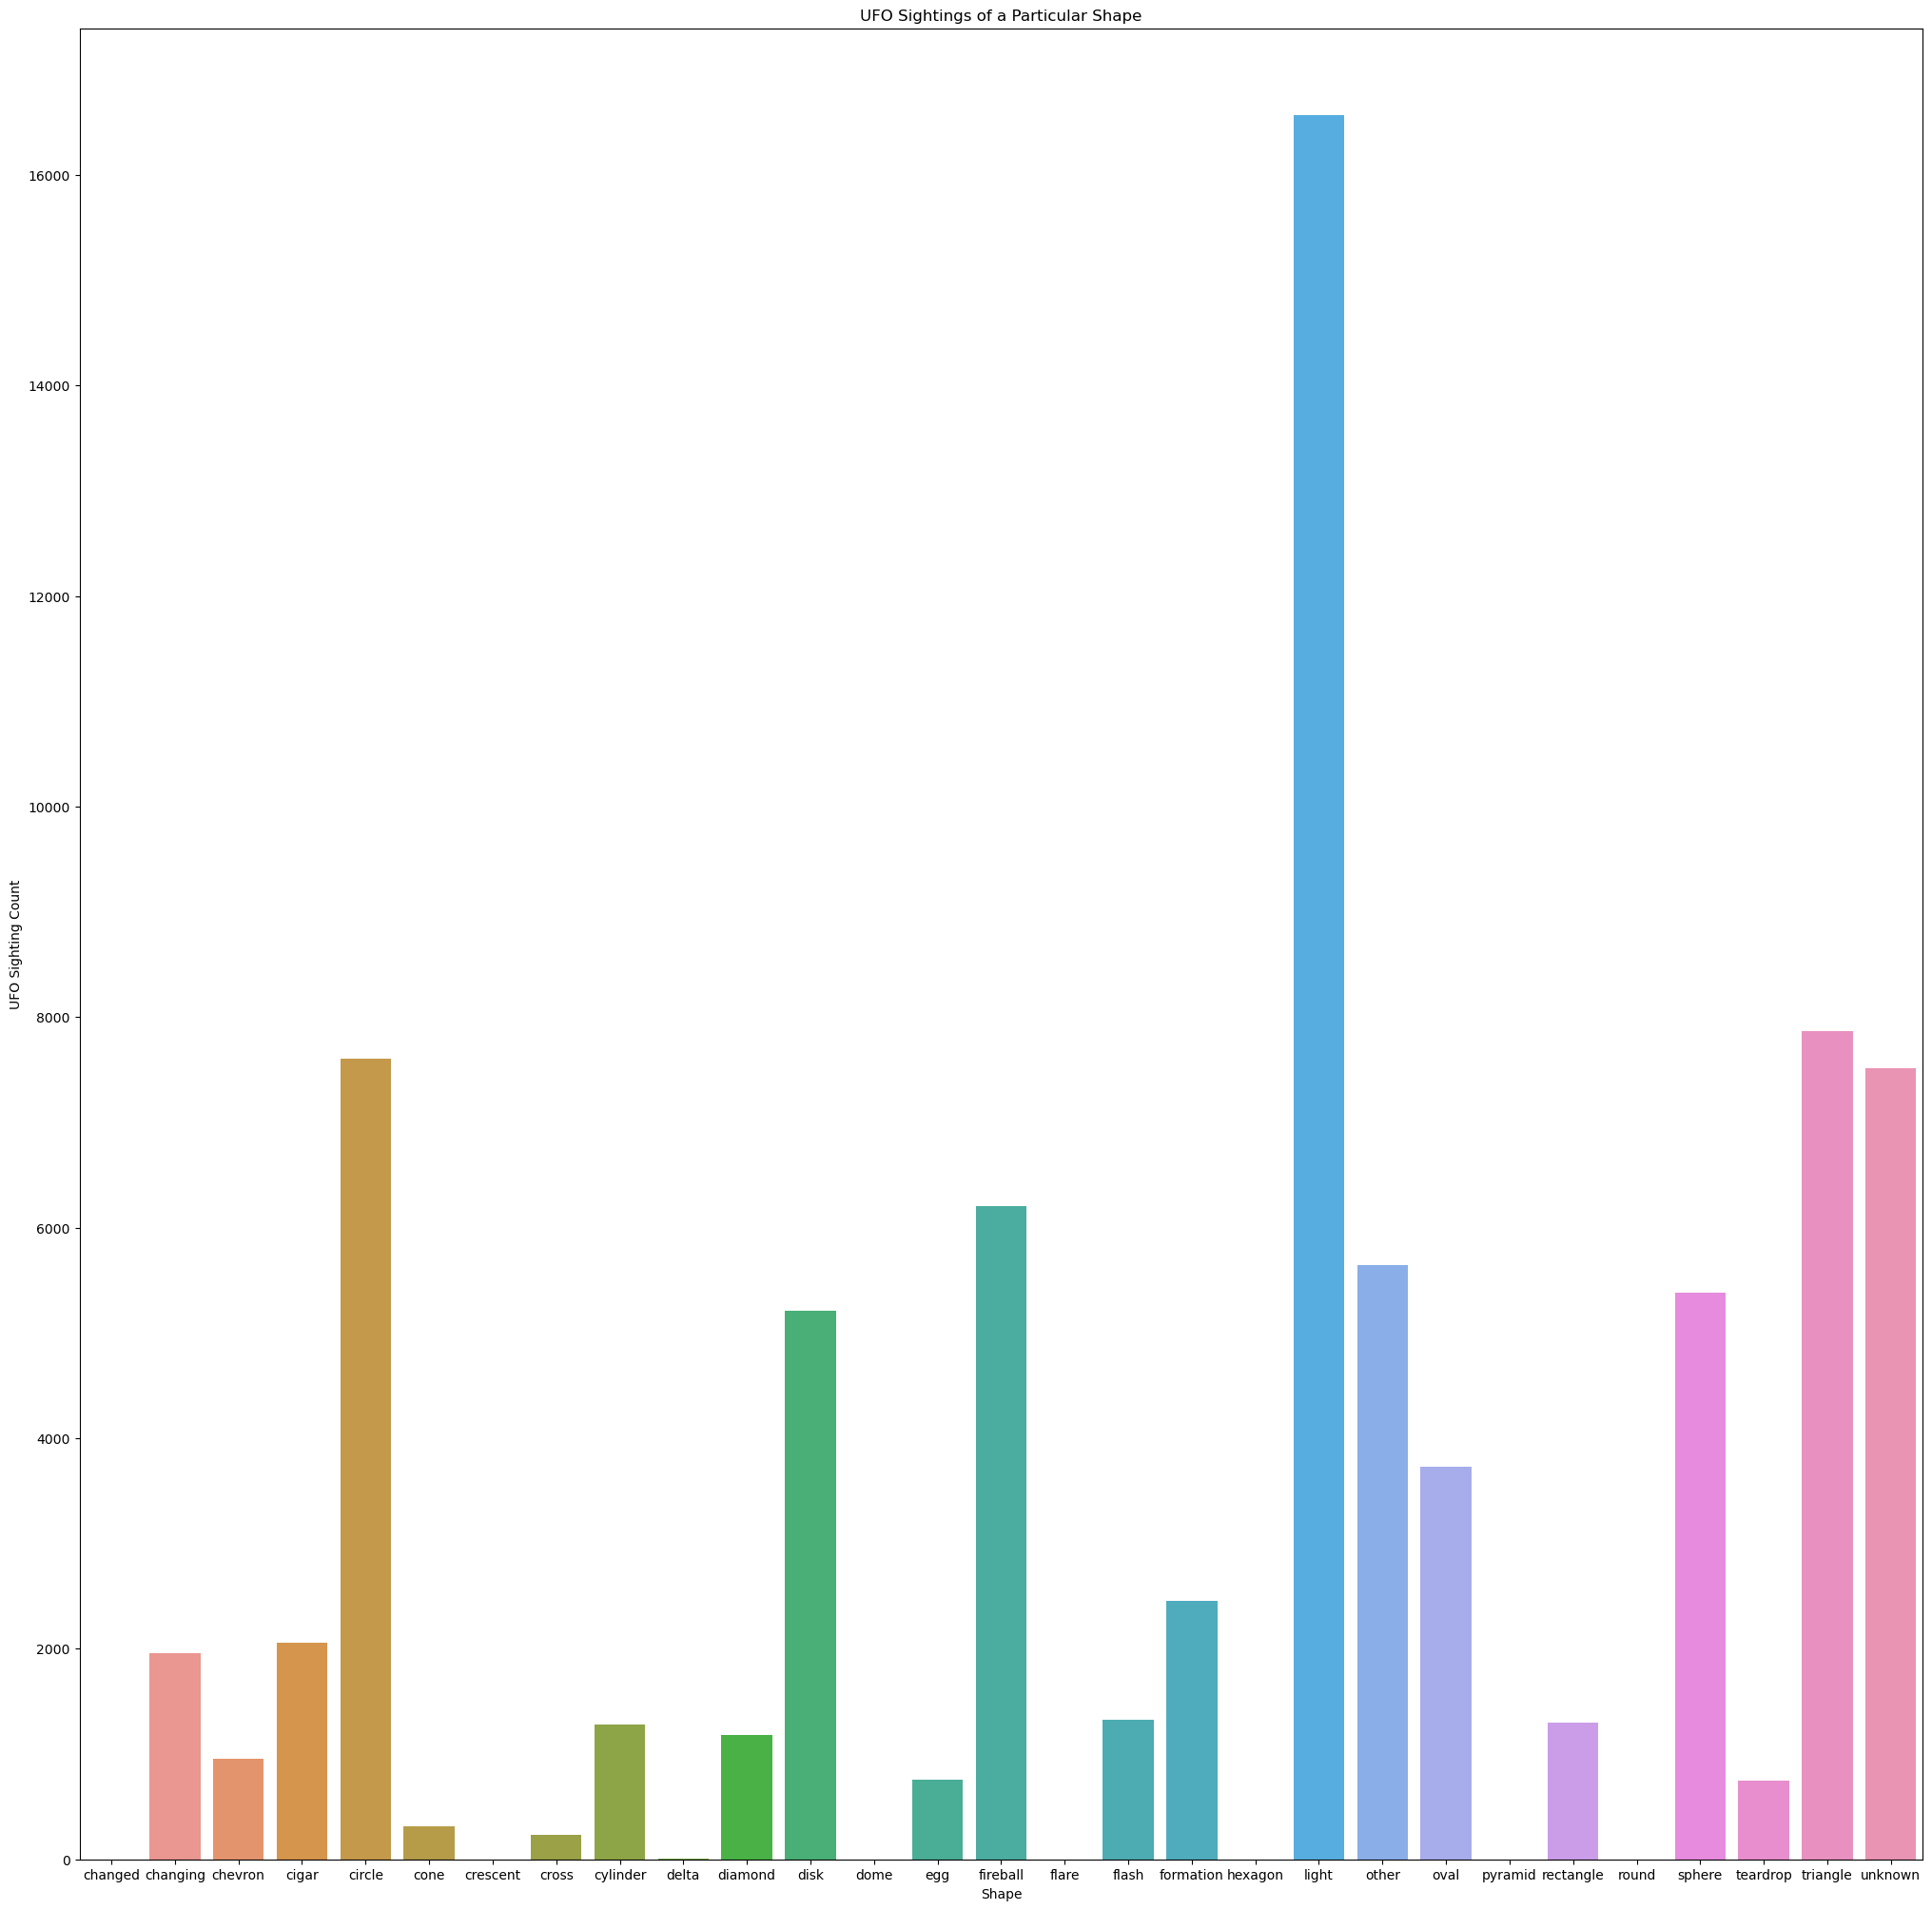

In [6]:
# Next, since UFOs are a topic we are still learning and studying about, it would also be important to analyze them through
# their shape. 

# Thus, with the data at hand, we can first analyze how many UFO sightings of a particular shape have occurred.

# The following command counts the number of unique values in the 'Shape' column in the UFO dataframe.
UFO_Shape_Count = UFO_Dataframe.groupby('Shape').size().reset_index()

# Rename the columns for better understanding.
UFO_Shape_Count.columns = ["Shape", "Count"]

UFO_Shape_Count.head()

fig, ax = plt.subplots(figsize=(25, 25))

UFO_Shape_Count_plot = sns.barplot(data = UFO_Shape_Count, x = "Shape", y = "Count")

UFO_Shape_Count_plot = UFO_Shape_Count_plot.set(xlabel = "Shape", ylabel = "UFO Sighting Count", title ='UFO Sightings of a Particular Shape')

plt.show()

# Thus, the following plot shows the number of UFO sightings of a particular shape. It can be inferred that most of the 
# sightings were reported to have shape of "moving light". A substantial number of sightings also were circular and triangular
# in shape. A good number of UFO sightings were also hard to describe and thus were reported with a shape of "unknown".

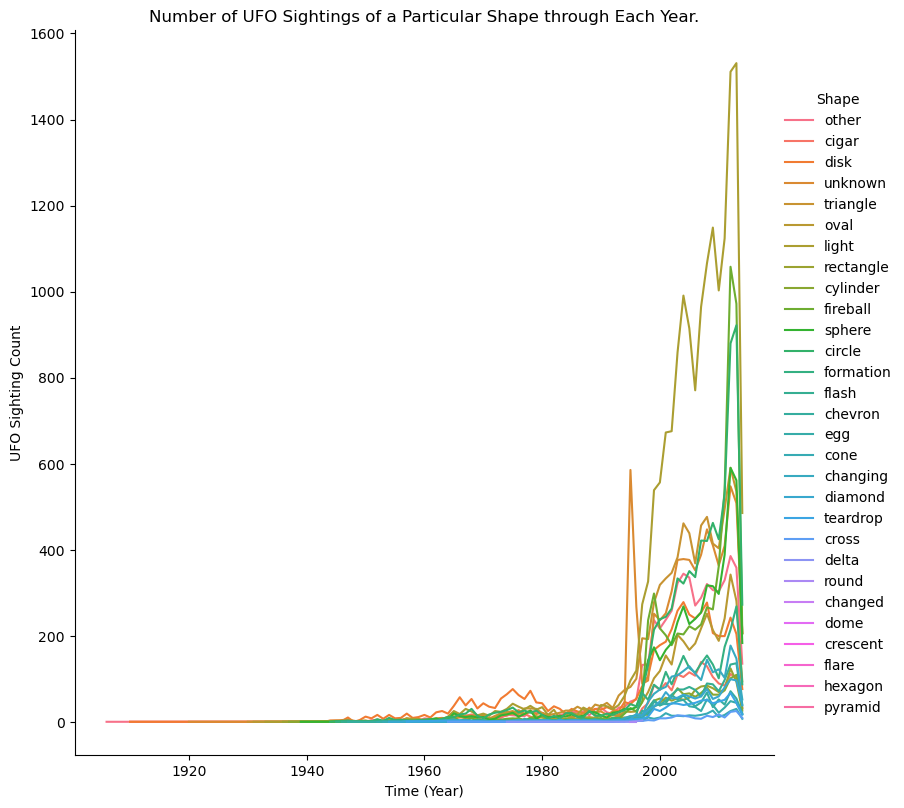

In [7]:
# Next, in the same vein we can analyze the shape of the UFO sightings with respect to time (in years) to see if any particular
# shape is particularly seen more often (over time).

UFO_Shape_Time = UFO_Dataframe

# Extract the Year from the datetime object.
UFO_Shape_Time["Year Observed"] = pd.DatetimeIndex(UFO_Shape_Time["Date Observed"]).year

# We do not really need the other columns in the plot we hope to achieve.
UFO_Shape_Time = UFO_Shape_Time[["Year Observed", "Shape"]]

# The following line computes the number of UFO sightings of a particular shape through each year.
UFO_Shape_Time = UFO_Shape_Time.groupby(['Year Observed', 'Shape']).size().reset_index()

UFO_Shape_Time.columns = ["Year Observed", "Shape", "Count"]

UFO_Shape_Time.head()


UFO_Shape_Time_plot = sns.relplot(data = UFO_Shape_Time, x = "Year Observed", y = "Count", height = 8, aspect = 1, hue = "Shape", kind = "line")

UFO_Shape_Time_plot = UFO_Shape_Time_plot.set(xlabel = "Time (Year)", ylabel = "UFO Sighting Count", title = 'Number of UFO Sightings of a Particular Shape through Each Year.')

plt.show()

# The following line plot shows that overall the number of UFO sightings for each shape increases over time. Particularly,
# we can see an obvious increase in the number of "moving light" shaped UFOs over time, which nearly had close to 1600 sightings
# in a single year itself. Moreover, in the late 1990's, there was a sudden spike of UFO sightings whose shape was ambiguous
# and hard to determine. Lastly, towards the end we can also see a small spike in UFO sightings that have a shape constituing
# of "fireball" and "circle".

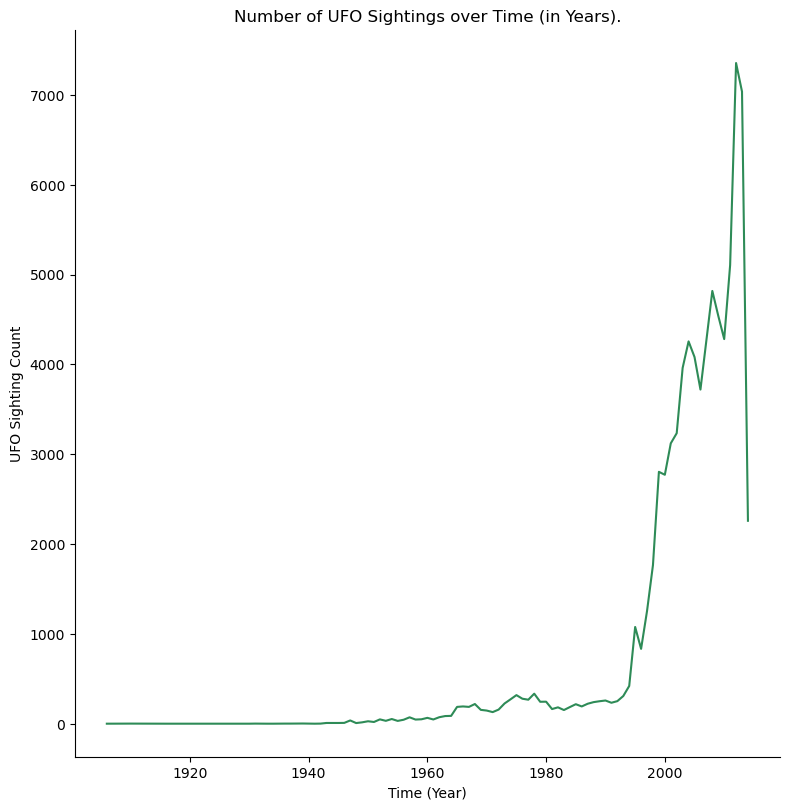

In [157]:
# Given our analysis on the aspect of "shape" of the UFO sightings, the above line plot seems to hint on the idea that the 
# number of UFO sightings over time has substantially increased. 

# Thus, we can now analyze this more concretely, to see a correlation between UFO sightings and Time (in years) in general.

UFO_Sightings_Time = UFO_Dataframe

# Extract the Year from the datetime object.
UFO_Sightings_Time["Year Observed"] = pd.DatetimeIndex(UFO_Sightings_Time["Date Observed"]).year

# We do not really need the other columns in the plot we hope to achieve.
UFO_Sightings_Time = UFO_Sightings_Time[["Year Observed"]]

UFO_Sightings_Time = UFO_Sightings_Time.groupby('Year Observed').size().reset_index()

UFO_Sightings_Time.columns = ["Year Observed", "Count"]

UFO_Sightings_Time.head()


UFO_Sightings_Time_plot = sns.relplot(data = UFO_Sightings_Time, x = "Year Observed", y = "Count", height = 8, aspect = 1, kind = "line", color = "seagreen")

UFO_Sightings_Time_plot = UFO_Sightings_Time_plot.set(xlabel = "Time (Year)", ylabel = "UFO Sighting Count", title = 'Number of UFO Sightings over Time (in Years).')

plt.show()

# From the line plot below, the upward trend of the graph unequivocally suggests that UFO sightings in general have 
# significantly increased over time (in years). 
# Particularly, post 2000 there has been a sharp increase in the number of UFO sightings.
# In the same vein, towards the end of the plot (compared to the beginning of around 0 sightings) it can also be inferred 
# that over 7000 sightings were observed in a single year!